In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import nashpy as nash

In [3]:
import repeated_play

In [94]:
from tqdm.notebook import tqdm

In [88]:
def calc_payoffs_and_cooperation_rates(
    p1_strategy, p2_strategy, payoffs_p1, payoffs_p2
):
    M = repeated_play.transition_matrix_repeated_game(
        p1_strategy * 2, p2_strategy * 2, memory="one"
    )

    ss = repeated_play.stationary_distribution(M)[0]

    coop1 = ss[0] + ss[1]

    coop2 = ss[0] + ss[2]

    return (ss @ payoffs_p1, ss @ payoffs_p2, coop1, coop2)

In [16]:
def introspection_dynamics_one_shot(
    game, initial_state, beta, max_timesteps
):
    """
    Runs introspection dynamics for 2x2 one shot games.

    Parameters
    ----------
    game : nash.game
        The game.
    initial_state : tuple
        The initial strategies of the players
    payoff_matrix : float
        The seleection strenght.
    max_timesteps : int
        Number of learning steps in the introspection dynamic.

    Returns
    -------
    array
        An array with the strategies adopted by the two players over the learning time.
    """

    payoffs_row_player = game.payoff_matrices[0]
    payoffs_col_player = game.payoff_matrices[1].T

    payoffs = [payoffs_row_player, payoffs_col_player]

    strategies = initial_state

    states = np.zeros((max_timesteps, 2))

    states[0, :] = initial_state

    for timestep in range(max_timesteps):
        # Select a random player and then define the coplayer
        # For the player get their current strategy and their alternative

        who_updates, coplayer = np.random.choice(
            [0, 1], 2, replace=False
        )

        current_strategy = strategies[who_updates]

        alternative_strategy = abs(1 - current_strategy)

        co_players_strategy = strategies[coplayer]

        # Define the current payoff and the alternative
        # Update based on the fermi function

        current_payoff = payoffs[who_updates][
            current_strategy
        ][co_players_strategy]

        alternative_payoff = payoffs[who_updates][
            alternative_strategy
        ][co_players_strategy]

        update_probability = 1 / (
            np.e
            ** (
                -beta
                * (alternative_payoff - current_payoff)
            )
        )

        if update_probability > np.random.random():
            strategies[who_updates] = alternative_strategy

        states[timestep, :] = strategies

    return states

In [98]:
def introspection_dynamics_repeated_game(
    game, initial_strategies, beta, max_timesteps
):
    """
    Runs introspection dynamics for repeated games between two player.

    We assume that players use reactive-1 strategies. These are strategies that
    react to the co-players previous turn and they can be defined by a 2 dimensional
    vector. Namely a reactive-1 strategy is given by p = (pC, pD) where.

    Parameters
    ----------
    game : nash.game
        The game.
    initial_state : tuple
        The initial strategies of the players
    payoff_matrix : float
        The seleection strenght.
    max_timesteps : int
        Number of learning steps in the introspection dynamic.

    Returns
    -------
    array
        An array with the strategies adopted by the two players over the learning time.
    """

    payoffs_p1 = game.payoff_matrices[0].flatten()
    payoffs_p2 = game.payoff_matrices[1].T.flatten()

    payoffs = [payoffs_p1, payoffs_p2]

    p1_strategy = initial_strategies[0]
    p2_strategy = initial_strategies[1]

    strategies = [p1_strategy, p2_strategy]

    data_over_learning = np.zeros((max_timesteps, 8))

    (
        current_payoff_p1,
        current_payoff_p2,
        coop1,
        coop2,
    ) = calc_payoffs_and_cooperation_rates(
        p1_strategy, p2_strategy, payoffs_p1, payoffs_p2
    )

    data_over_learning[0, :] = [*p1_strategy, *p2_strategy, coop1, coop2, current_payoff_p1, current_payoff_p2]

    for timestep in tqdm(range(max_timesteps)):
        # Select a random player and then define the coplayer
        # For the player get their current strategy and their alternative

        who_updates, coplayer = np.random.choice([0, 1], 2, replace=False)

        current_strategy = strategies[who_updates]

        alternative_strategy = list(np.random.random(2))

        co_players_strategy = strategies[coplayer]

        # Define the current payoff and the alternative
        # Update based on the fermi function

        (
            current_payoff_up,
            current_payoff_cop,
            coop_up,
            coop_cop,
        ) = calc_payoffs_and_cooperation_rates(
            current_strategy * 2, co_players_strategy, payoffs_p1, payoffs_p2
        )

        (
            alternative_payoff_up,
            alternative_payoff_cop,
            alternative_coop_up,
            alternative_coop_cop,
        ) = calc_payoffs_and_cooperation_rates(
            alternative_strategy * 2, co_players_strategy * 2, payoffs_p1, payoffs_p2
        )

        update_probability = 1 / (
            np.e ** (-beta * (alternative_payoff_up - current_payoff_up))
        )

        if update_probability > np.random.random():
            strategies[who_updates] = alternative_strategy

            coop_up = alternative_coop_up

            coop_cop = alternative_coop_cop
            
            current_payoff_up = alternative_payoff_up
            
            current_payoff_cop = alternative_coop_cop

        data_over_learning[timestep, :] = [
            *strategies[0],
            *strategies[1],
            coop_up,
            coop_cop,
            current_payoff_up,
            current_payoff_cop
        ]

    return data_over_learning

In [8]:
def plot_introspection_trajectory(result):
    x, y = zip(*result)

    fig, axes = plt.subplots(ncols=2, figsize=(10, 3.5))

    axes[0].plot(x, color="tab:red")
    axes[1].plot(y, color="tab:blue")

    axes[0].set_title("Row player actions")
    axes[1].set_title("Column player actions")

    for ax in axes:
        ax.set_ylabel("probability of playing A")
        ax.set_xlabel("timesteps")

In [9]:
def plot_introspection_states_distribution(result):
    dict_ = {
        (1, 1): "(D, D)",
        (0, 0): "(C, C)",
        (0, 1): "(C, D)",
        (1, 0): "(D, C)",
    }

    result_transformed = [dict_[i] for i in result]

    fig, ax = plt.subplots()

    ax.bar(
        range(4),
        [
            result_transformed.count(state) / len(result)
            for state in [
                "(C, C)",
                "(C, D)",
                "(D, C)",
                "(D, D)",
            ]
        ],
    )

    ax.set_xticks(
        range(4), ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
    )

    ax.set_ylabel("frequency")

    return fig, ax

In [10]:
def introspection_over_betas(
    game, initial_state, beta, max_timesteps
):
    dict_ = {
        (1, 1): "(D, D)",
        (0, 0): "(C, C)",
        (0, 1): "(C, D)",
        (1, 0): "(D, C)",
    }

    betas = [10**i for i in np.linspace(-2, 2, 20)]

    payoffs = game.payoff_matrices[0]

    states = []

    for beta in betas:
        result = introspection_dynamics(
            game, initial_state, beta, max_timesteps
        )
        result_transformed = [dict_[i] for i in result]

        states.append(
            [
                result_transformed.count(state)
                / max_timesteps
                for state in list(dict_.values())
            ]
        )

    fig, ax = plt.subplots()

    ax.plot(states, label=list(dict_.values()))

    ax.set_xticks([0, 20], [0, 100])

    ax.set_xlabel("strenght of selection")

    ax.legend()


#     return fig, ax

In [29]:
def f(x):
    return x[0] + (x[1] == 1) * 2

## Prisoner's dilemma

In [7]:
payoffs = [[3, 0], [5, 1]]

dict_ = {
    (1, 1): "(D, D)",
    (0, 0): "(C, C)",
    (0, 1): "(C, D)",
    (1, 0): "(D, C)",
}

In [8]:
payoffs_row_player = np.array([[3, 0], [5, 1]])
payoffs_col_player = np.array([[3, 5], [0, 1]])

game = nash.Game(payoffs_row_player, payoffs_col_player)
game

Bi matrix game with payoff matrices:

Row player:
[[3 0]
 [5 1]]

Column player:
[[3 5]
 [0 1]]

In [17]:
results = introspection_dynamics_one_shot(game, [0, 0], 5, 10 ** 3)

In [19]:
results

array([[1., 0.],
       [1., 0.],
       [1., 1.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [41]:
def introspection_over_betas(
    game, initial_state, max_timesteps
):

    betas = [10**i for i in np.linspace(-2, 2, 20)]

    states = []

    for beta in betas:
        results = introspection_dynamics_one_shot(
            game, initial_state, beta, max_timesteps
        )
        
        outcomes = np.array(list(map(f, results)))
        
        unique, counts = np.unique(outcomes, return_counts=True)
        
        dicts_ = dict(zip(unique, counts))

        states.append(
            [
                dicts_[i]
                / max_timesteps
                for i in range(3)
            ]
        )

    fig, ax = plt.subplots()

    ax.plot(states, label=['CC', "CD", "DC", "DD"])

    ax.set_xticks([0, 20], [0, 100])

    ax.set_xlabel("strenght of selection")

    ax.legend()

    return fig, ax

In [71]:
b, c1, c2 = 1, 0.6, 0.1

In [75]:
payoffs_row_player = np.array([[b -c1, -c1], [0, 0]])
payoffs_col_player = np.array([[b - c2, 0], [-c2, 0]])

game = nash.Game(payoffs_row_player, payoffs_col_player)
game

Bi matrix game with payoff matrices:

Row player:
[[ 0.4 -0.6]
 [ 0.   0. ]]

Column player:
[[ 0.9  0. ]
 [-0.1  0. ]]

In [76]:
initial_state = [0, 0]

max_timesteps = 5 * 10 ** 3

betas = [10**i for i in np.linspace(-2, 2, 20)]

states = []


for beta in betas:
    
    dicts_ = {0: 0, 1: 0, 2: 0, 3: 0}
    
    results = introspection_dynamics_one_shot(
        game, initial_state, beta, max_timesteps
    )

    outcomes = np.array(list(map(f, results)))

    unique, counts = np.unique(outcomes, return_counts=True)

    for key, val in zip(unique, counts):
        dicts_[key] = val / max_timesteps
    
    states.append(list(dicts_.values()))

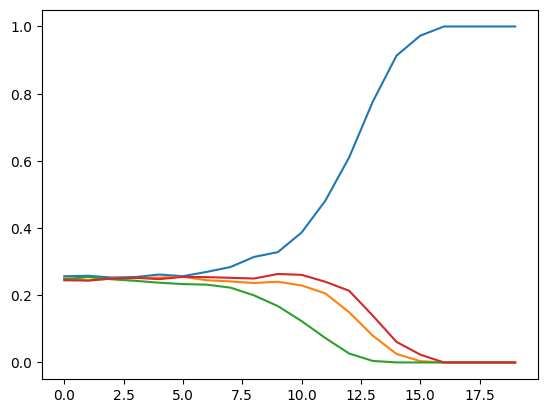

In [77]:
plt.plot(states, label=['CC', "CD", "DC", "DD"]);

### Repeated

From the Laura paper.

In [118]:
beta = 20

b = 1

c = 0.1

payoffs_row_player = np.array([[b - c, -c], [0, 0]])
payoffs_col_player = np.array([[b - c, 0], [-c, 0]])

game = nash.Game(payoffs_row_player, payoffs_col_player)
game

Bi matrix game with payoff matrices:

Row player:
[[ 0.9 -0.1]
 [ 0.   0. ]]

Column player:
[[ 0.9  0. ]
 [-0.1  0. ]]

In [119]:
data = introspection_dynamics_repeated_game(
    game, [[0 for _ in range(2)], [0 for _ in range(2)]], beta, 10 ** 5
)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [127]:
# plt.plot(data[:, 2])

# plt.plot(data[:, 3])



# # plt.plot(data[:, -2])

In [117]:
data[-1]

array([0.96432445, 0.93279153, 0.86618723, 0.93548576, 0.86894587,
       0.96019193, 0.74746023, 0.74746023])